In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras import layers, models, initializers, Input
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Загрузка данных
images = np.load("/kaggle/input/dl-captcha-new/mds-misis-dl-captchan/images.npy")
labels = np.load("/kaggle/input/dl-captcha-new/mds-misis-dl-captchan/labels.npy")

print(images.shape)
print(labels.shape)

(20000, 48, 48, 3)
(20000,)


In [3]:
print(images[0])
print(labels[0])

[[[144 109 189]
  [153 122 179]
  [169 143 163]
  ...
  [158 130 175]
  [149 117 183]
  [131  91 200]]

 [[128  87 203]
  [138 101 193]
  [160 132 172]
  ...
  [158 129 175]
  [152 121 181]
  [132  93 199]]

 [[127  86 204]
  [135  96 197]
  [145 111 188]
  ...
  [158 129 175]
  [152 121 181]
  [132  93 198]]

 ...

 [[147 115 185]
  [159 131 174]
  [168 142 165]
  ...
  [159 130 174]
  [154 123 179]
  [137 100 194]]

 [[130  90 201]
  [143 108 189]
  [165 138 168]
  ...
  [159 130 175]
  [153 122 180]
  [131  91 200]]

 [[130  90 201]
  [138 102 194]
  [139 102 193]
  ...
  [158 129 175]
  [148 116 184]
  [128  87 203]]]
13


Для подготовки данных выполним нормализацию изображений, преобразовав значения пикселей из диапазона [0, 255] в [0, 1], затем представим метки в виде отдельных столбцов и разделим набор данных на обучающую и валидационную части.

In [4]:
# Нормализация значений пикселей из диапазона [0, 255] в [0, 1]
images = images / 255.0

# Преобразование меток в формат one-hot encoding для 26 классов
labels = tf.keras.utils.to_categorical(labels, num_classes=26)

# Разделение данных на обучающую и валидационную выборки (80% / 20%)
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

## Создание модели

In [9]:
model = models.Sequential([
    # Явно задаём форму входа через Input-слой
    Input(shape=(48, 48, 3)),

    # Первый сверточный блок
    layers.Conv2D(64, (3, 3), padding='same', activation='relu',
                  kernel_initializer='he_normal'),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu',
                  kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Второй сверточный блок
    layers.Conv2D(128, (3, 3), padding='same', activation='relu',
                  kernel_initializer='he_normal'),
    layers.Conv2D(128, (3, 3), padding='same', activation='relu',
                  kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Третий сверточный блок
    layers.Conv2D(256, (3, 3), padding='same', activation='relu',
                  kernel_initializer='he_normal'),
    layers.Conv2D(256, (3, 3), padding='same', activation='relu',
                  kernel_initializer='he_normal'),
    layers.BatchNormalization(),

    # Глобальный средний пулинг
    layers.GlobalAveragePooling2D(),

    # Полносвязный слой
    layers.Dense(256, activation='relu', kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    # Выходной слой с softmax
    layers.Dense(26, activation='softmax')
])

In [10]:
initial_learning_rate = 0.001

# Используем экспоненциальное уменьшение шага обучения с "теплым стартом" (warmup)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=1000,       # через сколько шагов уменьшается LR
    decay_rate=0.9,         # множитель снижения LR
    staircase=True          # если True — LR уменьшается ступенчато, иначе плавно
)

# Создаем оптимизатор Adam с динамическим шагом обучения
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Компиляция модели с категорической кросс-энтропией и метрикой accuracy
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Вывод архитектуры модели
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 48, 48, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 26)                  │           6,682 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,220,698 (4.66 MB)

 Trainable params: 1,219,290 (4.65 MB)

 Non-trainable params: 1,408 (5.50 KB)

Модель имеет 1 220 698 параметров

## Обучение модели

Проведем обучение на 50 эпохах.

In [11]:
# Коллбэк для ранней остановки, чтобы избежать переобучения
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # мониторим валидационную точность
    patience=5,              # ждать 5 эпох без улучшения
    restore_best_weights=True,  # вернуть веса лучшей эпохи после остановки
    verbose=1
)

# Дополнительно можно добавить уменьшение шага обучения при плато
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',      # мониторим валидационную потерю
    factor=0.5,              # уменьшаем LR в 2 раза
    patience=3,              # ждать 3 эпохи без улучшения
    min_lr=1e-6,             # минимальное значение LR
    verbose=1
)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],  # добавляем коллбэки
    shuffle=True,                           # перемешиваем данные перед каждой эпохой (по умолчанию True)
    verbose=1                              # прогресс в консоли
)

Epoch 1/50


I0000 00:00:1749756491.471651     104 service.cc:148] XLA service 0x7f53c4006b80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749756491.472419     104 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1749756492.039662     104 cuda_dnn.cc:529] Loaded cuDNN version 90300


 16/500 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.0343 - loss: 4.6217      

I0000 00:00:1749756496.345077     104 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - accuracy: 0.0428 - loss: 3.9388 - val_accuracy: 0.0420 - val_loss: 3.3274 - learning_rate: 0.0010
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.0519 - loss: 3.4898 - val_accuracy: 0.0617 - val_loss: 3.5041 - learning_rate: 9.0000e-04
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.0790 - loss: 3.2648 - val_accuracy: 0.0873 - val_loss: 3.0943 - learning_rate: 9.0000e-04
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.2148 - loss: 2.6268 - val_accuracy: 0.5395 - val_loss: 1.5575 - learning_rate: 8.1000e-04
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.6718 - loss: 1.0576 - val_accuracy: 0.7803 - val_loss: 0.7215 - learning_rate: 8.1000e-04
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.8362 - loss: 0.5396 - val_accuracy: 0.8195 - val_loss: 0.5991 - learning_rate: 7.2900e-04
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.8856 

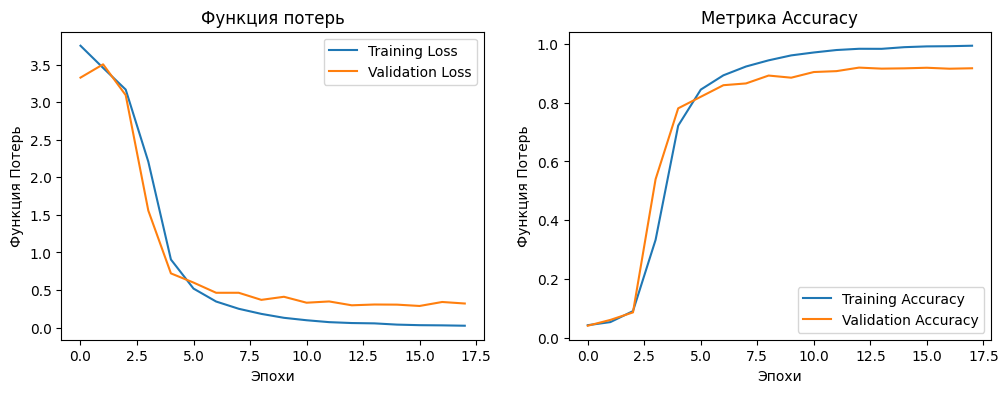

In [12]:
# Визуализация результатов обучения 
plt.figure(figsize=(12, 4))

# Функция потерь
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Функция потерь')
plt.xlabel('Эпохи')
plt.ylabel('Функция Потерь')
plt.legend()

# Метрика Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Метрика Accuracy')
plt.xlabel('Эпохи')
plt.ylabel('Функция Потерь')
plt.legend()

plt.show()

In [13]:
# Загрузка массива изображений для предсказания
images_sub = np.load("/kaggle/input/dl-captcha-new/mds-misis-dl-captchan/images_sub.npy")

# Проверка формы (опционально)
print(f"Shape of test images: {images_sub.shape}")

# Нормализация пикселей из диапазона [0, 255] в [0, 1]
images_sub = images_sub.astype('float32') / 255.0

# Предсказания модели: вероятности для каждого класса
predictions = model.predict(images_sub)

# Получаем класс с максимальной вероятностью для каждого примера
predicted_classes = predictions.argmax(axis=1)

# Формируем DataFrame для submission с Id и предсказанным классом
submission = pd.DataFrame({
    'Id': range(len(predicted_classes)),
    'Category': predicted_classes
})

# Сохраняем результаты в CSV файл без индексов
submission.to_csv('/kaggle/working/submission.csv', index=False)

print("Submission saved to /kaggle/working/submission.csv")

Shape of test images: (50000, 48, 48, 3)
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
Submission saved to /kaggle/working/submission.csv
